<h2> Music Genre Classification with RNN-LSTM Model: </h2>

In [1]:
import json
import librosa
import numpy as np
import tensorflow as tf

/Users/xenexjoshi/Music Genre Classification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Filepath of encoded data generated from the function in data_loader.py
DATA_PATH = "data.json"

def load_data(data_path = DATA_PATH):
  """
  load_data(data_path) accesses the json file defined by data_path and extracts
  the MFCC data with associated labels for the .wav files located in the subfolders
  of data/ extracted using generate_features() function in data_loader.py.
  """

  # Loading the .json file to read the data
  with open(data_path, "r") as fp:
    data = json.load(fp)

   # Collecting the MFCC vectors and labels
  mfcc = np.array(data["mfcc"])
  labels = np.array(data["labels"])
  
  return mfcc, labels

In [3]:
# Loading the MFCC data from data.json
mfcc, labels = load_data(DATA_PATH)

# Generating higher-order delta MFCC from the MFCC vectors
delta_mfcc = librosa.feature.delta(mfcc, order = 1)
delta2_mfcc = librosa.feature.delta(mfcc, order = 2)

print(mfcc.shape)
print(delta_mfcc.shape)
print(delta2_mfcc.shape)

(9989, 132, 13)
(9989, 132, 13)
(9989, 132, 13)


In [4]:
from sklearn.model_selection import train_test_split

def split_data(features, labels):
  """
  split_data(features, labels) splits the input data (features, labels) into training
  set, validation set, and testing set split as 60-10-30 i.e. 60% of the input data
  makes up the training set, 10% makes up the validation set, and 30% makes up the
  testing set.
  """
  
  X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.30, random_state = 42)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, random_state = 42)
  return X_train, X_test, X_val, y_train, y_test, y_val

X_train, X_test, X_validation, y_train, y_test, y_validation = split_data(np.stack([mfcc, delta_mfcc, delta2_mfcc], axis = -1), labels)

input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
print(input_shape)

(132, 13, 3)


In [5]:
import tensorflow.keras as keras

# Initializing the LSTM model
lstm_model = keras.Sequential()

# Adding a convolution + flatten layer to convert 4D data into LSTM processable data
lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv1D(filters = 32, kernel_size = 3, activation = 'relu'), 
                                  input_shape = input_shape))
lstm_model.add(keras.layers.TimeDistributed(keras.layers.BatchNormalization()))
lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv1D(filters = 64, kernel_size = 3, activation='relu')))
lstm_model.add(keras.layers.TimeDistributed(keras.layers.BatchNormalization()))
lstm_model.add(keras.layers.TimeDistributed(keras.layers.Flatten()))

# Adding the LSTM layers (One layer is switched to GRU to speed-up the training time)
lstm_model.add(keras.layers.LSTM(64, return_sequences = True, dropout = 0.2, recurrent_dropout = 0.2))
lstm_model.add(keras.layers.GRU(128, return_sequences = True, dropout = 0.3, recurrent_dropout = 0.3))
lstm_model.add(keras.layers.LSTM(128, dropout = 0.3, recurrent_dropout = 0.3))

# Adding Dense layers to reduce the nodes in the model to condense the model information
lstm_model.add(keras.layers.Dense(256, activation = 'relu'))
lstm_model.add(keras.layers.Dropout(0.4))
lstm_model.add(keras.layers.Dense(128, activation = 'relu'))
lstm_model.add(keras.layers.Dropout(0.4))

# Condensing neuron layer into 10 nodes, each corresponding to a music genre label
lstm_model.add(keras.layers.Dense(10, activation = 'softmax'))

# Adding Adam optimizer and loss function to the LSTM model
lstm_model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001),
                   loss = 'sparse_categorical_crossentropy',
                   metrics = ['accuracy'])

lstm_model.summary()

/Users/xenexjoshi/Music Genre Classification/.venv/lib/python3.9/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 132, 11, 32)    │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 132, 11, 32)    │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 132, 9, 64)     │         6,208 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 132, 9, 64)     │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 132, 576)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 132, 64)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 132, 128)       │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 444,298 (1.69 MB)

 Trainable params: 444,106 (1.69 MB)

 Non-trainable params: 192 (768.00 B)

In [6]:
# Initializing early-stopping to avoid over-fitting the RNN-LSTM model
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

# Initializing dynaic learning rates
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, min_lr = 1e-6)

In [7]:
# Training the RNN-LSTM model with early_stopping and dynamic learning rates
history = lstm_model.fit(X_train, y_train, 
                        validation_data = (X_validation, y_validation),
                        batch_size = 32,
                        epochs = 20,
                        callbacks = [early_stopping, reduce_lr])

Epoch 1/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 212s 999ms/step - accuracy: 0.2403 - loss: 2.0899 - val_accuracy: 0.3775 - val_loss: 1.6861 - learning_rate: 0.0010
Epoch 2/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 178s 956ms/step - accuracy: 0.3929 - loss: 1.6916 - val_accuracy: 0.4538 - val_loss: 1.4551 - learning_rate: 0.0010
Epoch 3/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 182s 979ms/step - accuracy: 0.4290 - loss: 1.5975 - val_accuracy: 0.4757 - val_loss: 1.4286 - learning_rate: 0.0010
Epoch 4/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.4807 - loss: 1.4446 - val_accuracy: 0.5214 - val_loss: 1.3017 - learning_rate: 0.0010
Epoch 5/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 183s 983ms/step - accuracy: 0.5262 - loss: 1.3294 - val_accuracy: 0.5920 - val_loss: 1.1845 - learning_rate: 0.0010
Epoch 6/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 185s 993ms/step - accuracy: 0.5664 - loss: 1.2615 - val_accuracy: 0.6177 - val_loss: 1.1241 - learning_rate: 0.0010
Epoch 7/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 177s 950ms/step - accuracy:

In [8]:
# Evaluating model performance with the testing set
_, accuracy = lstm_model.evaluate(X_test, y_test)
print("Model accuracy: " + str(round(100 * accuracy, 3)) + "%.")

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.7368 - loss: 0.7633
Model accuracy: 75.042%.


<h3> Analysis: </h3>

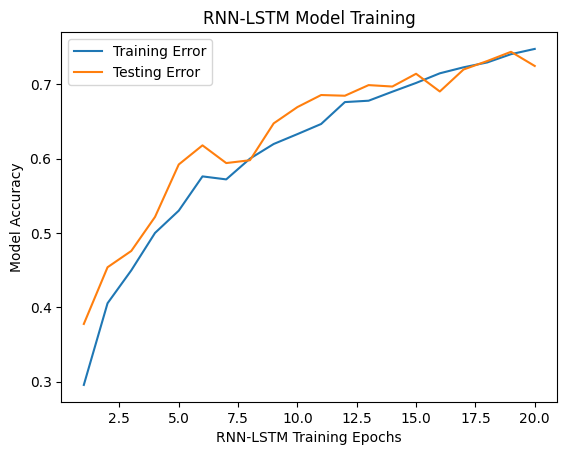

In [9]:
import matplotlib.pyplot as plt

# Plotting the training error and validation error to check for overfitting
x_range = range(1, 21)
plt.plot(x_range, history.history['accuracy'], label = 'Training Error')
plt.plot(x_range, history.history['val_accuracy'], label = 'Testing Error')
plt.xlabel('RNN-LSTM Training Epochs')
plt.ylabel('Model Accuracy')
plt.title('RNN-LSTM Model Training')
plt.legend()
plt.show()